In [1]:
# import all the relevant libraries

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import h5py

import keras
from keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Input, InputLayer, Dropout
import keras.layers.merge as merge
from keras.layers.merge import Concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam

%matplotlib inline

2021-11-05 09:38:08.011471: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
# check for CPU and GPU for your session

print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices('CPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [4]:
# load data and check the train-test split shape and size

(x_train, y_train), (x_valid, y_valid) = cifar10.load_data()
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_valid.shape, y_valid.shape))
print('number of classes= %s' %len(set(y_train.flatten())))
print(type(x_train))

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)
number of classes= 10
<class 'numpy.ndarray'>


In [5]:
# specify classes from the cifar10 dataset

nb_classes = 10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

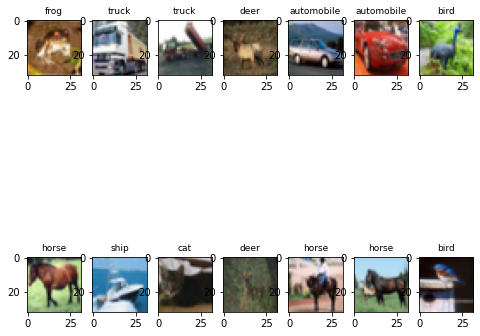

In [6]:
# plotting some examples from training dataset

plt.figure(figsize=(8, 8)) 
for i in range(2*7):
    # define subplot
    plt.subplot(2, 7, i+1)
    plt.imshow(x_train[i])
    class_index = np.argmax(to_categorical(y_train[i], 10))
    plt.title(class_names[class_index], fontsize=9)

In [4]:
# convert data to HDF5 format

with h5py.File('dataset_cifar10.hdf5', 'w') as hf:
    dset_x_train = hf.create_dataset('x_train', data=x_train, shape=(50000, 32, 32, 3), compression='gzip', chunks=True)
    dset_y_train = hf.create_dataset('y_train', data=y_train, shape=(50000, 1), compression='gzip', chunks=True)
    dset_x_test = hf.create_dataset('x_valid', data=x_valid, shape=(10000, 32, 32, 3), compression='gzip', chunks=True)
    dset_y_test = hf.create_dataset('y_valid', data=y_valid, shape=(10000, 1), compression='gzip', chunks=True)

In [7]:
# Define the model

model = tf.keras.Sequential()
model.add(InputLayer(input_shape=[32, 32, 3]))

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=[2,2], strides=[2, 2], padding='same'))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=[2,2], strides=[2, 2], padding='same'))

model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=[2,2], strides=[2, 2], padding='same'))

model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=[2,2], strides=[2, 2], padding='same'))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(10, activation='softmax'))

model.summary()

2021-11-05 09:39:46.720666: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-05 09:39:46.723179: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1c:00.0 name: NVIDIA Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2021-11-05 09:39:46.723228: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-11-05 09:39:46.723260: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-11-05 09:39:46.723278: I tensorflow/stream_execu

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         2

In [8]:
# Define the data generator

class DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, filename, batch_size, test=False, shuffle=True):
        
        self.PATH_TO_FILE = filename
        
        self.hf = h5py.File(self.PATH_TO_FILE, 'r')         
        self.batch_size = batch_size
        self.test = test
        self.shuffle = shuffle
        self.on_epoch_end()

    def __del__(self):
        self.hf.close()
        
    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, idx):
        start = self.batch_size * idx
        stop = self.batch_size * (idx+1)
        
        if self.test:
            x = self.hf['x_valid'][start:stop, ...]
            batch_x = np.array(x).astype('float32') / 255.0
            y = self.hf['y_valid'][start:stop]
            batch_y = to_categorical(np.array(y), 10)
        else:
            x = self.hf['x_train'][start:stop, ...]
            batch_x = np.array(x).astype('float32') / 255.0
            y = self.hf['y_train'][start:stop]
            batch_y = to_categorical(np.array(y), 10)

        return batch_x, batch_y

    def on_epoch_end(self):
        if self.test:
            self.indices = np.arange(self.hf['x_valid'][:].shape[0])
        else:
            self.indices = np.arange(self.hf['x_train'][:].shape[0])
            
        if self.shuffle:
            np.random.shuffle(self.indices)

In [9]:
# generate batches of data for training and validation dataset

filename = "dataset_cifar10.hdf5"
batchsize  = 250 
data_train = DataGenerator(filename, batch_size=batchsize, test=False)
data_valid = DataGenerator(filename, batch_size=batchsize, test=True, shuffle=False)

In [10]:
# defining optimizer for the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# first, let's train the model using CPU

with tf.device('/device:CPU:0'):
    history = model.fit(data_train,epochs=10,
                        verbose=1, validation_data=data_valid)

2021-11-03 19:34:24.178121: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-03 19:34:24.178701: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2593905000 Hz


Epoch 1/10
200/200 [==============================] - 122s 605ms/step - loss: 1.9766 - accuracy: 0.2546 - val_loss: 1.3989 - val_accuracy: 0.4817
Epoch 2/10
200/200 [==============================] - 123s 612ms/step - loss: 1.3606 - accuracy: 0.4988 - val_loss: 1.1279 - val_accuracy: 0.5962
Epoch 3/10
200/200 [==============================] - 120s 600ms/step - loss: 1.1002 - accuracy: 0.6015 - val_loss: 0.9965 - val_accuracy: 0.6425
Epoch 4/10
200/200 [==============================] - 121s 607ms/step - loss: 0.9377 - accuracy: 0.6683 - val_loss: 0.9115 - val_accuracy: 0.6789
Epoch 5/10
200/200 [==============================] - 123s 616ms/step - loss: 0.8076 - accuracy: 0.7129 - val_loss: 0.8413 - val_accuracy: 0.7089
Epoch 6/10
200/200 [==============================] - 124s 619ms/step - loss: 0.6993 - accuracy: 0.7528 - val_loss: 0.8158 - val_accuracy: 0.7188
Epoch 7/10
200/200 [==============================] - 123s 613ms/step - loss: 0.5836 - accuracy: 0.7963 - val_loss: 0.8112 -

In [11]:
# now, lets try with GPU to compare its performance with CPU

from tensorflow.keras.models import clone_model
new_model = clone_model(model)
opt = keras.optimizers.Adam(learning_rate=0.001)
new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

with tf.device('/device:GPU:0'):
    new_history = new_model.fit(data_train,epochs=10,
                                verbose=1, validation_data=data_valid)

2021-11-05 09:40:12.068057: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-05 09:40:12.069649: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz


Epoch 1/10


2021-11-05 09:40:12.826687: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-11-05 09:40:13.650429: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-11-05 09:40:18.322067: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2021-11-05 09:40:18.344211: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


200/200 [==============================] - 31s 112ms/step - loss: 1.9554 - accuracy: 0.2611 - val_loss: 1.3775 - val_accuracy: 0.4867
Epoch 2/10
200/200 [==============================] - 22s 107ms/step - loss: 1.3312 - accuracy: 0.5118 - val_loss: 1.1199 - val_accuracy: 0.5972
Epoch 3/10
200/200 [==============================] - 22s 107ms/step - loss: 1.0894 - accuracy: 0.6091 - val_loss: 1.0114 - val_accuracy: 0.6380
Epoch 4/10
200/200 [==============================] - 22s 107ms/step - loss: 0.9305 - accuracy: 0.6724 - val_loss: 0.8875 - val_accuracy: 0.6906
Epoch 5/10
200/200 [==============================] - 22s 107ms/step - loss: 0.7863 - accuracy: 0.7260 - val_loss: 0.8183 - val_accuracy: 0.7180
Epoch 6/10
200/200 [==============================] - 22s 107ms/step - loss: 0.6875 - accuracy: 0.7561 - val_loss: 0.8020 - val_accuracy: 0.7271
Epoch 7/10
200/200 [==============================] - 22s 107ms/step - loss: 0.5863 - accuracy: 0.7952 - val_loss: 0.8094 - val_accuracy: 0.7

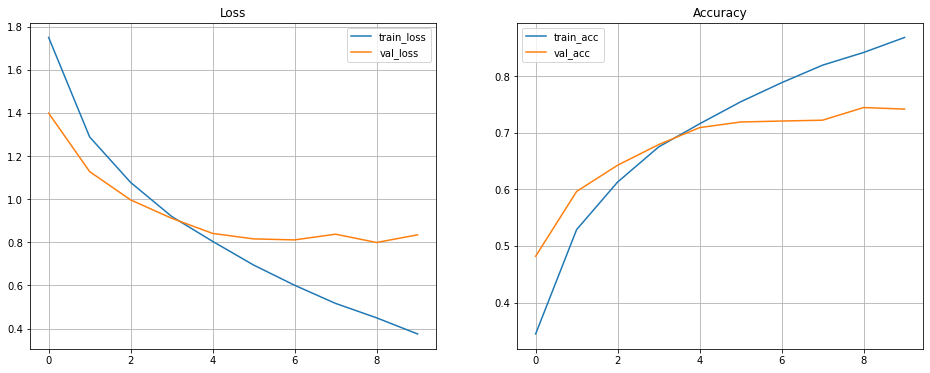

In [13]:
# plotting the losses and accuracy for training and validation set

fig, axes = plt.subplots(1,2, figsize=[16, 6])
axes[0].plot(history.history['loss'], label='train_loss')
axes[0].plot(history.history['val_loss'], label='val_loss')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].grid()
axes[1].plot(history.history['accuracy'], label='train_acc')
axes[1].plot(history.history['val_accuracy'], label='val_acc')
axes[1].set_title('Accuracy')
axes[1].legend()
axes[1].grid()

In [14]:
x = x_valid.astype('float32') / 255.0
y = to_categorical(y_valid, 10)
score = new_model.evaluate(x, y, verbose=0)
print('Test cross-entropy loss: %0.5f' % score[0])
print('Test accuracy: %0.2f' % score[1])

Test cross-entropy loss: 0.83419
Test accuracy: 0.75


In [15]:
y_pred = new_model.predict_classes(x)

/home/ajaiswal/.conda/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


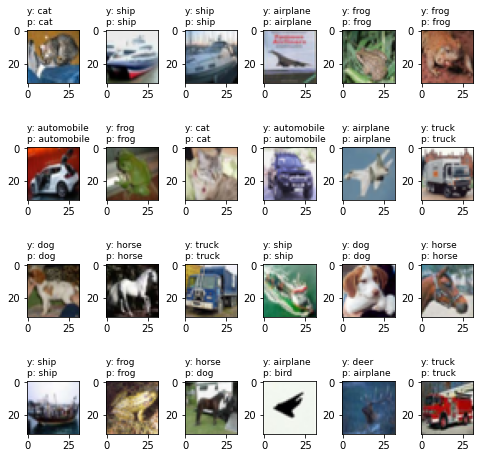

In [20]:
plt.figure(figsize=(8, 8)) 
for i in range(24):
    plt.subplot(4, 6, i+1)
    plt.imshow(x[i].reshape(32,32,3))
    index1 = np.argmax(y[i])
    plt.title("y: %s\np: %s" % (class_names[index1], class_names[y_pred[i]]), fontsize=9, loc='left')
    plt.subplots_adjust(wspace=0.5, hspace=0.4)

# Staging and File System Choice

##### Run this cell if you're not in your home directory

In [ ]:
cd

#### Challenge 1: Locate Lustre and NFS File System Scratch On MANA

#### Challenge 2: List Usage Information

#### Challenge 3: Simulating Read/Write Load

#### Challenge 4: Timing Read/Write Operations

##### Time Lustre Read

##### Time Lustre Write

##### Time NFS Read (from home directory)

##### Time NFS Write (from home directory)

#### Challenge 5: Stage Training Files

#### Challenge 6: Update Data Generator File Path 

#### Challenge 7: Rerun The Model With The Updated Data Generator